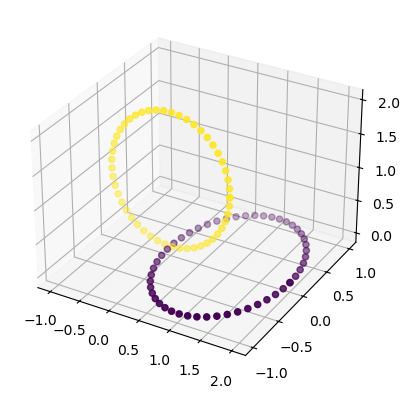

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
# Create a toy dataset of 2 interlocking rings in 3D and with 1000 points and labels for each point
# Create a toy dataset of interlocking rings perpendicular to each other in 3D
num_points = 50
theta = torch.linspace(0, 2 * torch.pi, num_points)

# First ring in the XY plane, centered at (1, 0, 0)
x1 = 1 + torch.cos(theta)
y1 = torch.sin(theta)
z1 = torch.zeros(num_points)

# Second ring in the XZ plane, centered at (0, 0, 1)
x2 = torch.cos(theta)
y2 = torch.zeros(num_points)
z2 = 1 + torch.sin(theta)

# Combine the rings
X1 = torch.stack([x1, y1, z1], dim=1)
X2 = torch.stack([x2, y2, z2], dim=1)
X = torch.cat([X1, X2], dim=0)

# Labels for the rings
Y1 = torch.zeros(num_points, dtype=torch.int32)
Y2 = torch.ones(num_points, dtype=torch.int32)
Y = torch.cat([Y1, Y2], dim=0)
# Plot the dataset
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=Y, cmap='viridis')
plt.show()


In [10]:
# Create a dataloader for the dataset
dataset = torch.utils.data.TensorDataset(X, Y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
# Split the dataset into a training and test set
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

In [11]:
import torch
from model.fully_connected_network import FullyConnectedNetwork
from core.energy import HopfieldEnergy
from core.updater import FixedPointUpdater
from training.runner import Runner
from training.cost import SquaredError
from training.equilibrium_propagation import EquilibriumProp
from util.config import Config

config = Config()
config.training["num_epochs"] = 5
network = FullyConnectedNetwork(config)
energy_fn = HopfieldEnergy(config)
cost_fn = SquaredError(config)
updater = FixedPointUpdater(network, energy_fn, cost_fn, config)

W, B = network.weights, torch.tensor(0.0) #network.bias # Need to verify if pointer or new creation. It should be pointer already but sanity check. 
optimizer = torch.optim.SGD([W, B], lr=0.01)
differentiator = EquilibriumProp(network, energy_fn, cost_fn, updater, config, optimizer)



config.path = "./results"

runner = Runner(config, network, train_loader, differentiator, updater, optimizer, inference_dataloader=None)
# runner.run_training()

In [12]:
runner.run_training()

Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0


Epochs:  20%|██        | 1/5 [00:03<00:12,  3.01s/it]

Epoch: 0, Energy: 0.0000, Accuracy: 0.5000
Epoch: 1


Epochs:  40%|████      | 2/5 [00:05<00:08,  2.96s/it]

Epoch: 1, Energy: 0.0000, Accuracy: 0.5000
Epoch: 2


Epochs:  60%|██████    | 3/5 [00:08<00:05,  2.99s/it]

Epoch: 2, Energy: 0.0000, Accuracy: 0.5000
Epoch: 3


Epochs:  80%|████████  | 4/5 [00:11<00:02,  2.98s/it]

Epoch: 3, Energy: 0.0000, Accuracy: 0.5000
Epoch: 4


Epochs: 100%|██████████| 5/5 [00:14<00:00,  2.99s/it]

Epoch: 4, Energy: 0.0000, Accuracy: 0.5000


0.5

In [4]:
network._layer_shapes

[3, 8, 8, 1]

In [5]:
import torch
from tqdm import tqdm


S, W, B = runner.training_epoch()

# Update network state
network._weights = W
network._state = S
network._biases = B
W1 = W[:]



Training Batches: 100%|██████████| 80/80 [00:02<00:00, 32.53it/s]


In [6]:
S, W, B = runner.training_epoch()


Training Batches: 100%|██████████| 80/80 [00:02<00:00, 34.70it/s]


In [8]:
mg = []
tr = []
for x, target in tqdm(runner._dataloader, desc="Training Batches"):
    # Zero gradients for current batch.
    runner._optimizer.zero_grad()
    # Set the input and retrieve current parameters.
    S = runner._network.set_input(x)
    # Assume the network has an attribute B representing the bias matrix.
    W, B = runner._network.weights, runner._network.biases
    # Let the network settle to equilibrium.
    S = runner._updater.compute_equilibrium(S, W, B, target)
    # Compute parameter gradients (assumed to return (weight_grads, bias_grads)).
    weight_grads, bias_grads = runner._differentiator.compute_gradient(S, W, B, target)
    # Assign gradients to the parameters.
    W.grad, B.grad = weight_grads, bias_grads
    # Update parameters.
    runner._optimizer.step()

    S = runner._updater.compute_equilibrium_pred(S, W, B)
    mg.append( S.flatten().detach().numpy()[-1])
    tr.append(target.flatten().detach().numpy()[-1])
    print(target, [round(a,3) for a in S.flatten().detach().numpy()[:]])
    # print()

Training Batches:   8%|▊         | 6/80 [00:00<00:02, 27.62it/s]

tensor([0], dtype=torch.int32) [0.428, 0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.289, 0.289, 0.289, 0.289, 0.289, 0.289, 0.289, 0.289, 0.0]
tensor([1], dtype=torch.int32) [0.518, 0.0, 0.145, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.238, 0.238, 0.238, 0.238, 0.238, 0.238, 0.238, 0.238, 0.0]
tensor([0], dtype=torch.int32) [0.099, 0.434, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.095, 0.0]
tensor([1], dtype=torch.int32) [-0.223, 0.0, 0.025, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.801, 0.0, 0.402, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.032, 0.0, 0.001, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Training Batches:  15%|█▌        | 12/80 [00:00<00:02, 27.83it/s]

tensor([1], dtype=torch.int32) [-0.345, 0.0, 1.938, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.285, -0.959, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.405, -0.914, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.518, 0.0, 1.855, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [0.777, -0.975, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.406]
tensor([1], dtype=torch.int32) [-0.096, 0.0, 1.995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


Training Batches:  22%|██▎       | 18/80 [00:00<00:02, 27.77it/s]

tensor([1], dtype=torch.int32) [0.285, 0.0, 0.041, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [0.405, 0.0, 1.914, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [0.992, 0.0, 0.872, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [-0.572, 0.0, 0.18, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [0.655, -0.938, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Training Batches:  30%|███       | 24/80 [00:00<00:02, 27.70it/s]

tensor([0], dtype=torch.int32) [1.801, -0.598, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.992, 0.128, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [-0.949, 0.0, 1.315, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.538]
tensor([1], dtype=torch.int32) [-0.998, 0.0, 0.936, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.107]
tensor([1], dtype=torch.int32) [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


Training Batches:  38%|███▊      | 30/80 [00:01<00:01, 27.44it/s]

tensor([0], dtype=torch.int32) [0.162, 0.546, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [-0.463, 0.0, 1.887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [1.518, -0.855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [-0.223, 0.0, 1.975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [0.904, 0.995, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [0.537, 0.887, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


Training Batches:  41%|████▏     | 33/80 [00:01<00:01, 27.38it/s]

tensor([0], dtype=torch.int32) [0.239, 0.648, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.479, 0.479, 0.479, 0.479, 0.479, 0.479, 0.479, 0.479, 0.0]
tensor([1], dtype=torch.int32) [0.927, 0.0, 0.625, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.674, 0.674, 0.674, 0.674, 0.674, 0.674, 0.674, 0.674, 0.0]
tensor([1], dtype=torch.int32) [-0.672, 0.0, 0.26, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.623, -0.782, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [0.018, -0.191, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Training Batches:  49%|████▉     | 39/80 [00:01<00:01, 25.43it/s]

tensor([1], dtype=torch.int32) [0.623, 0.0, 1.782, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [0.162, -0.546, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.032, 0.0, 1.999, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.285, 0.959, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Training Batches:  56%|█████▋    | 45/80 [00:01<00:01, 22.78it/s]

tensor([1], dtype=torch.int32) [-0.345, 0.0, 0.062, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05]
tensor([0], dtype=torch.int32) [1.967, -0.254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [0.051, -0.315, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [0.428, -0.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [0.967, 0.0, 0.746, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


Training Batches:  64%|██████▍   | 51/80 [00:01<00:01, 24.54it/s]

tensor([1], dtype=torch.int32) [0.405, 0.0, 0.086, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [-0.949, 0.0, 0.685, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.927, 0.375, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.718, 0.0, 0.304, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.16, 0.0, 1.987, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [-0.672, 0.0, 1.74, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Training Batches:  71%|███████▏  | 57/80 [00:02<00:00, 25.84it/s]

tensor([0], dtype=torch.int32) [0.328, 0.74, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [0.239, -0.648, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.069]
tensor([0], dtype=torch.int32) [1.518, 0.855, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [1.801, 0.598, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [1.967, 0.254, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [0.777, 0.975, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


Training Batches:  79%|███████▉  | 63/80 [00:02<00:00, 26.14it/s]

tensor([0], dtype=torch.int32) [1.405, 0.914, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [-0.998, 0.0, 1.064, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
tensor([0], dtype=torch.int32) [1.16, 0.987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [0.871, 0.0, 1.491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([1], dtype=torch.int32) [0.927, 0.0, 1.375, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.845, 0.845, 0.845, 0.845, 0.845, 0.845, 0.845, 0.845, 0.0]
tensor([0], dtype=torch.int32) [1.16, -0.987, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.227, 0.227, 0.227, 0.227, 0.227, 0.227, 0.227, 0.227, 0.0]


Training Batches:  86%|████████▋ | 69/80 [00:02<00:00, 26.89it/s]

tensor([0], dtype=torch.int32) [1.623, 0.782, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.722, 0.722, 0.722, 0.722, 0.722, 0.722, 0.722, 0.722, 0.0]
tensor([0], dtype=torch.int32) [1.992, -0.128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.624, 0.0]
tensor([0], dtype=torch.int32) [1.871, -0.491, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.522, 0.522, 0.522, 0.522, 0.522, 0.522, 0.522, 0.522, 0.0]
tensor([0], dtype=torch.int32) [1.718, 0.696, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.594, 0.594, 0.594, 0.594, 0.594, 0.594, 0.594, 0.594, 0.0]
tensor([1], dtype=torch.int32) [0.801, 0.0, 1.598, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.473, 0.0]
tensor([1], dtype=torch.int32) [-0.572, 0.0, 1.82, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.184, 0.184, 0.184, 0.184, 0.184, 0.184, 0.184, 0.184, 0.0]


Training Batches:  94%|█████████▍| 75/80 [00:02<00:00, 27.23it/s]

tensor([1], dtype=torch.int32) [0.992, 0.0, 1.128, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.443, 0.443, 0.443, 0.443, 0.443, 0.443, 0.443, 0.443, 0.0]
tensor([1], dtype=torch.int32) [-0.901, 0.0, 0.566, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [-0.982, 0.0, 1.191, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [0.537, -0.887, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([0], dtype=torch.int32) [1.927, -0.375, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [-0.761, 0.0, 1.648, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]


Training Batches: 100%|██████████| 80/80 [00:03<00:00, 26.23it/s]

tensor([1], dtype=torch.int32) [-0.096, 0.0, 0.005, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [-0.761, 0.0, 0.352, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.491]
tensor([1], dtype=torch.int32) [0.623, 0.0, 0.218, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
tensor([1], dtype=torch.int32) [0.285, 0.0, 1.959, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]
tensor([0], dtype=torch.int32) [1.032, 0.999, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]


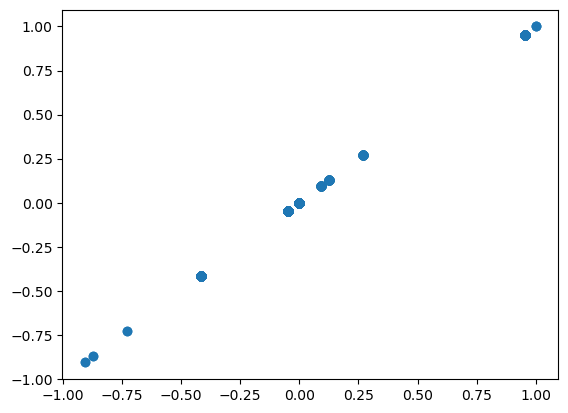

In [20]:
plt.scatter(W.flatten().detach().numpy(), W1.flatten().detach().numpy())

In [15]:
W1

tensor([[ 1.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  1.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  1.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.1276,  0.2698,  0.0934,  ..., -0.0468, -0.4151, -0.4151],
        [-0.8724, -0.7302, -0.9066,  ...,  0.9532, -0.4151, -0.4151],
        [-0.8724, -0.7302, -0.9066,  ...,  0.9532, -0.4151, -0.4151]],
       grad_fn=<AsStridedBackward0>)